# Data and packages

In [1]:
import squidpy as sq
import numpy as np
import pandas as pd
import numba.types as nt

import matplotlib.pyplot as plt

# pip install git+https://github.com/h2oai/datatable.git
import datatable

import os
import csv

In [2]:
os.getcwd()

'/Users/rafaeldossantospeixoto/Library/CloudStorage/OneDrive-JohnsHopkins/jefworks/crawdad/repos/crawdad_revision_analysis/running_code/squidpy'

In [3]:
meta = datatable.fread("exported_data/seq.csv")
meta = meta.to_pandas().set_index('C0')
meta.head()

x           y               celltypes
C0                                                
0   153.525805 -637.631290             Low quality
1   149.141916 -611.730670  Lateral plate mesoderm
2   202.464985 -665.246021               Erythroid
3   205.534050 -568.987205  Lateral plate mesoderm
4   202.076266 -678.072327               Erythroid

In [4]:
meta.shape

(19416, 3)

# Squidpy

In [5]:
# just some random data for gene expression because I'm just interested in getting the coordinates and labels in there
from anndata import AnnData
from numpy.random import default_rng
rng = default_rng(42)

counts = rng.integers(0, 15, size=(meta.shape[0], 50))
counts.shape

(19416, 50)

In [6]:
adata = AnnData(counts, obsm={"spatial": np.array(meta[["x", "y"]], dtype=float)})

In [7]:
adata.obs = meta

/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/anndata/_core/anndata.py:782: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [8]:
adata.obs

x           y                       celltypes
C0                                                           
0      153.525805 -637.631290                     Low quality
1      149.141916 -611.730670          Lateral plate mesoderm
2      202.464985 -665.246021                       Erythroid
3      205.534050 -568.987205          Lateral plate mesoderm
4      202.076266 -678.072327                       Erythroid
...           ...         ...                             ...
19411 -323.972924  602.040073                     Spinal cord
19412 -294.568998  717.725872                     Endothelium
19413 -318.722240  593.276218                     Spinal cord
19414 -292.490202  708.406387  Haematoendothelial progenitors
19415 -293.677287  583.291264                     Spinal cord

[19416 rows x 3 columns]

/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


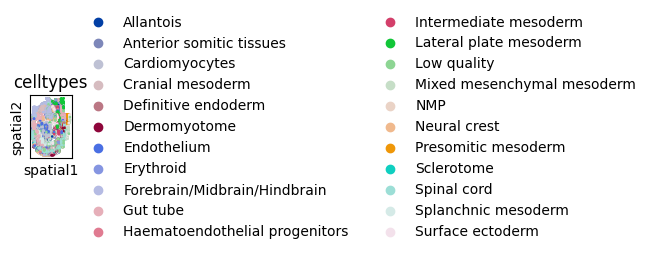

In [9]:
sq.pl.spatial_scatter(
        adata,
        shape = None,
        color = "celltypes",
        size=3
)

In [10]:
sq.gr.co_occurrence(adata, cluster_key = "celltypes", interval=np.linspace(1, 1000, num=50))


/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:29<00:00, 29.92s/]


In [11]:
adata

AnnData object with n_obs × n_vars = 19416 × 50
    obs: 'x', 'y', 'celltypes'
    uns: 'celltypes_colors', 'celltypes_co_occurrence'
    obsm: 'spatial'

In [12]:
## get the co-occurance values
occ = adata.uns["celltypes_co_occurrence"]["occ"]
occ.shape

(22, 22, 49)

In [13]:
## get the intervals
intervals = adata.uns["celltypes_co_occurrence"]["interval"]
intervals.shape

(50,)

/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_graph.py:367: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


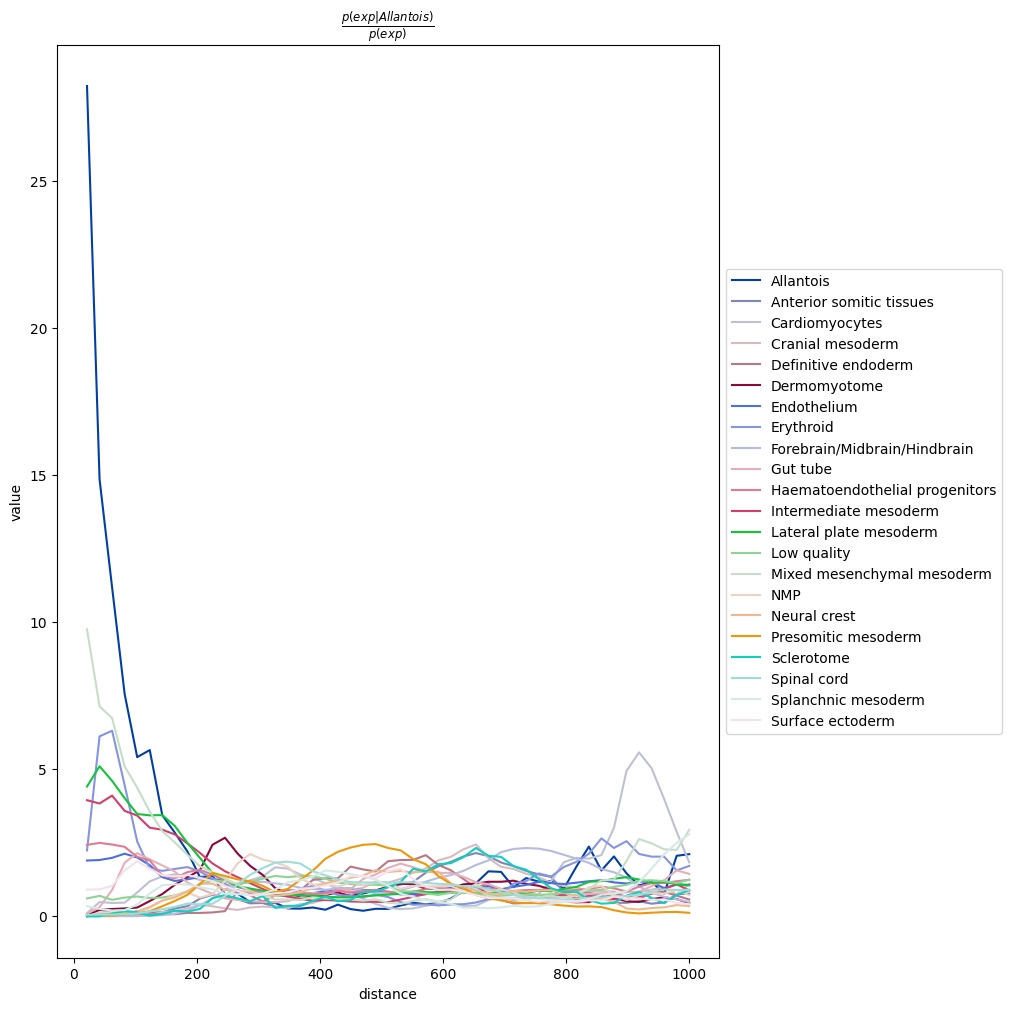

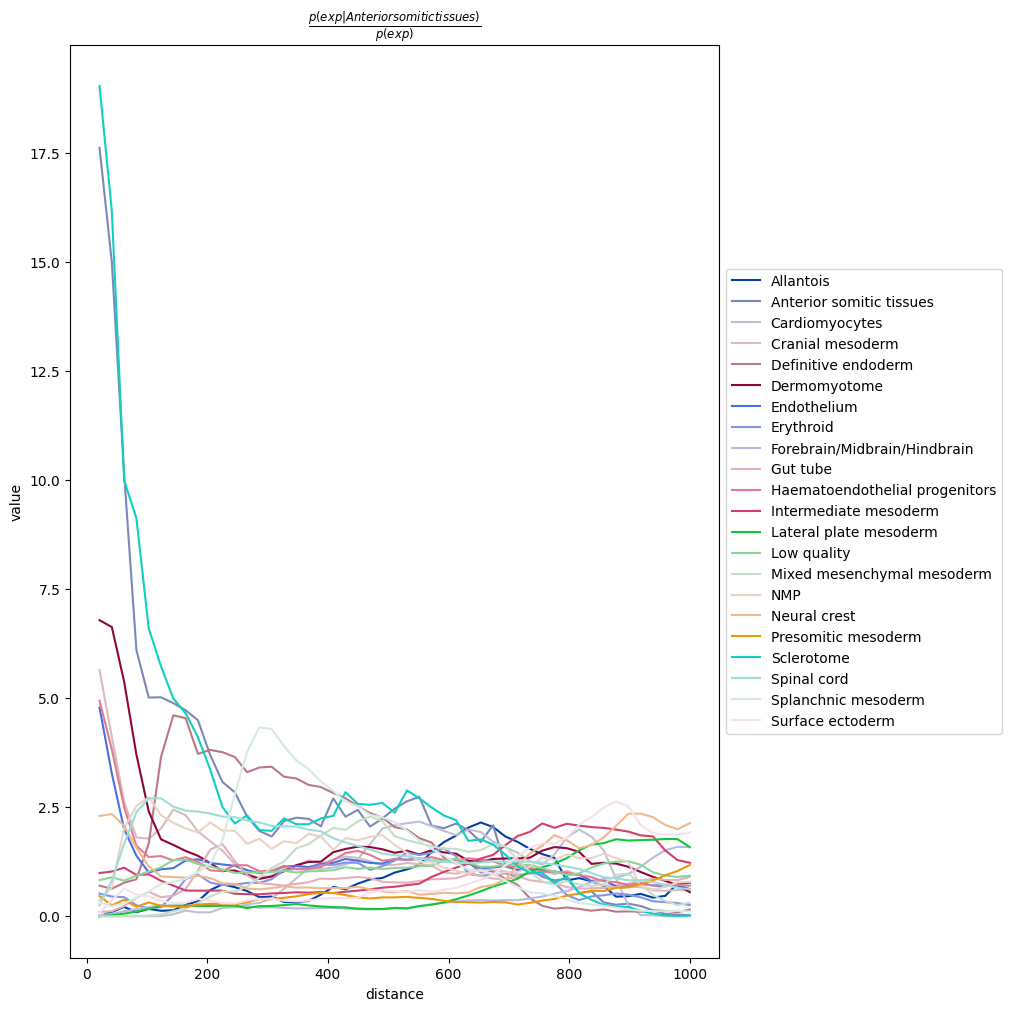

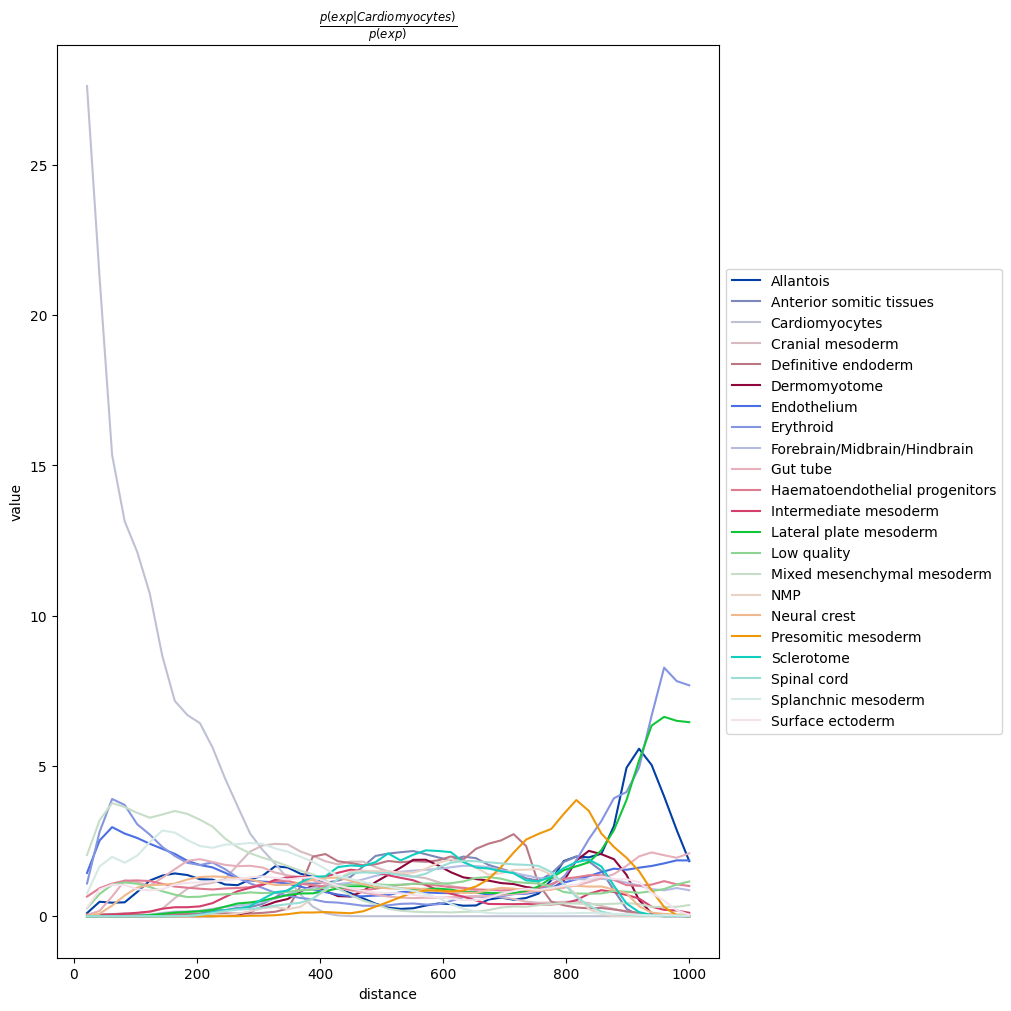

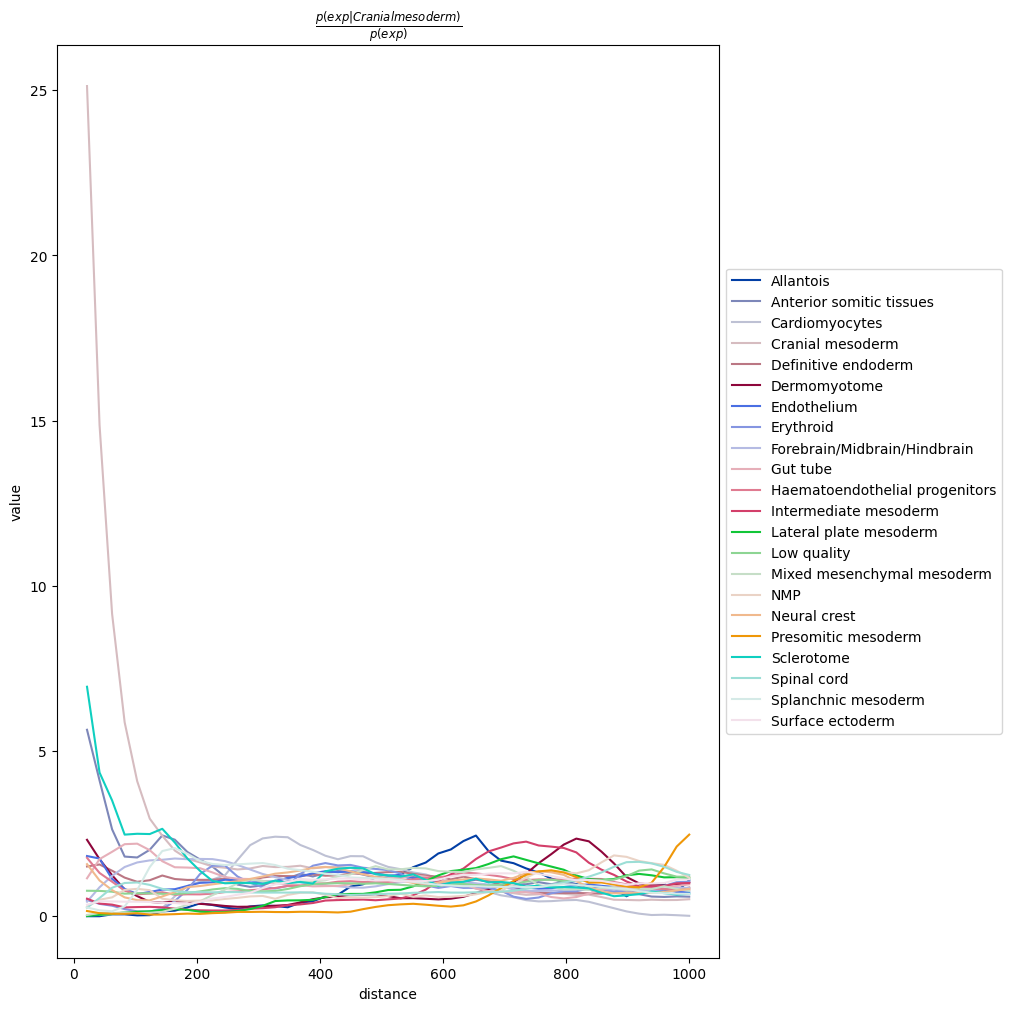

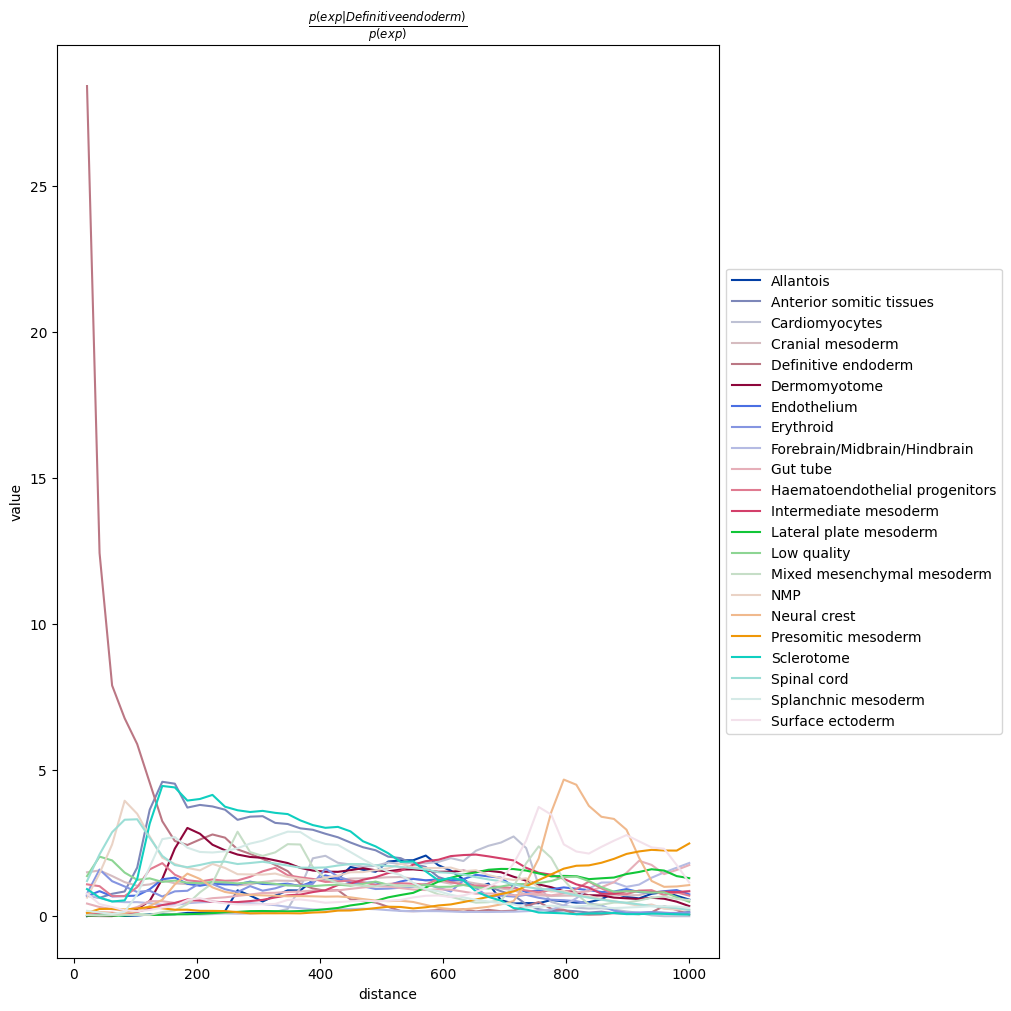

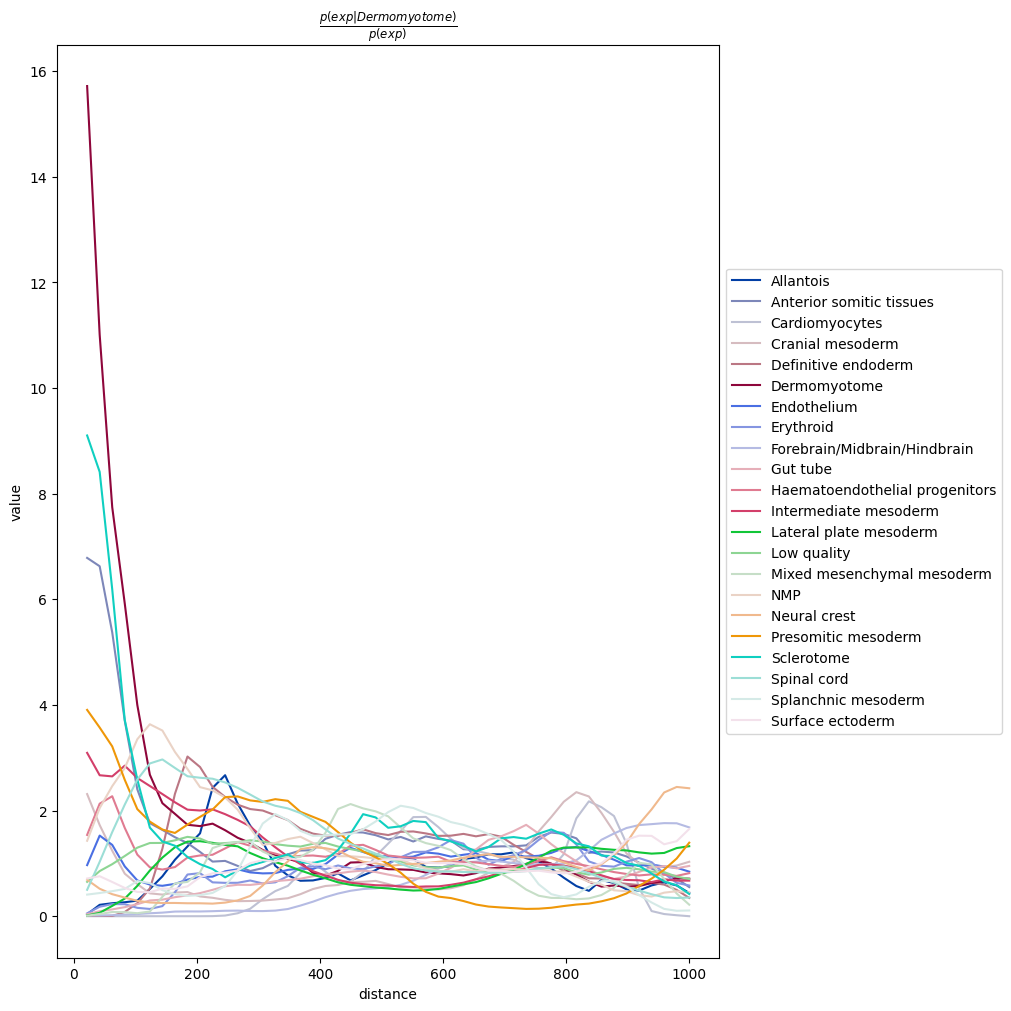

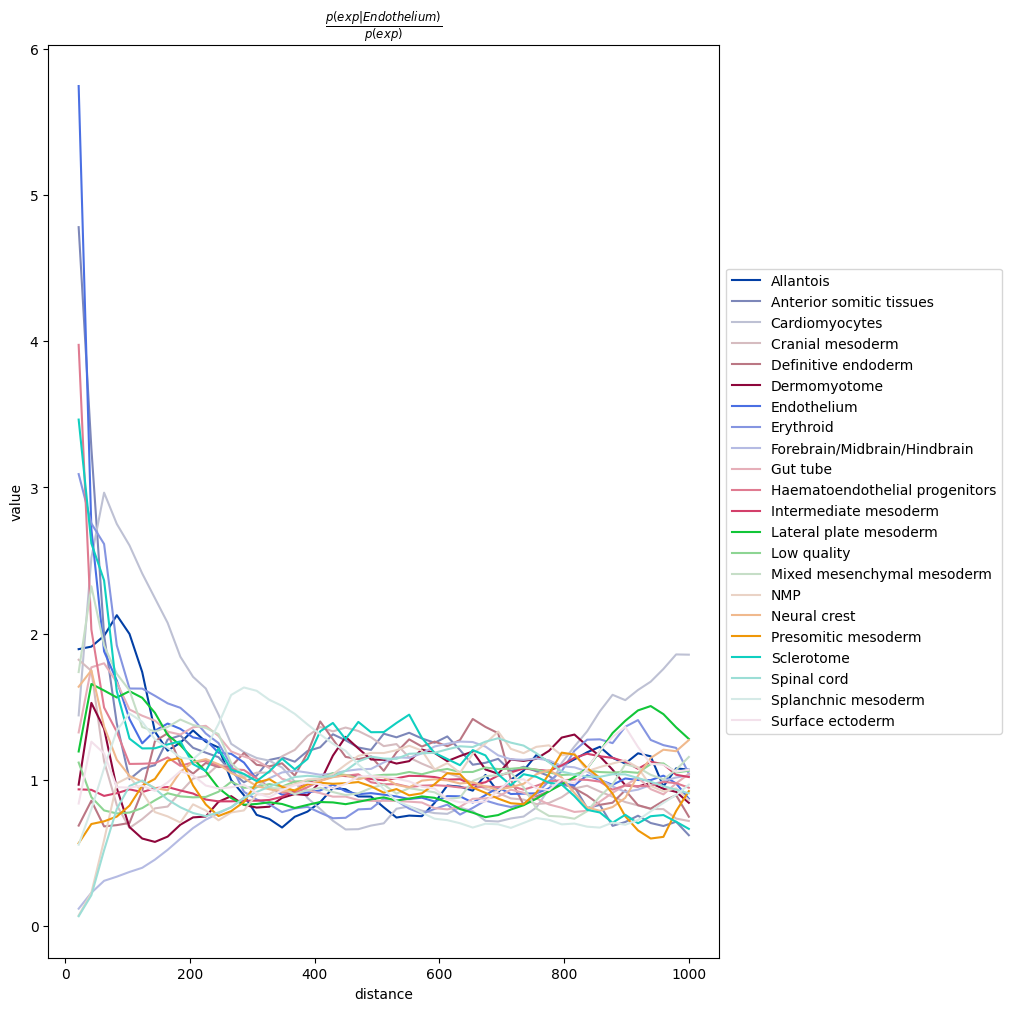

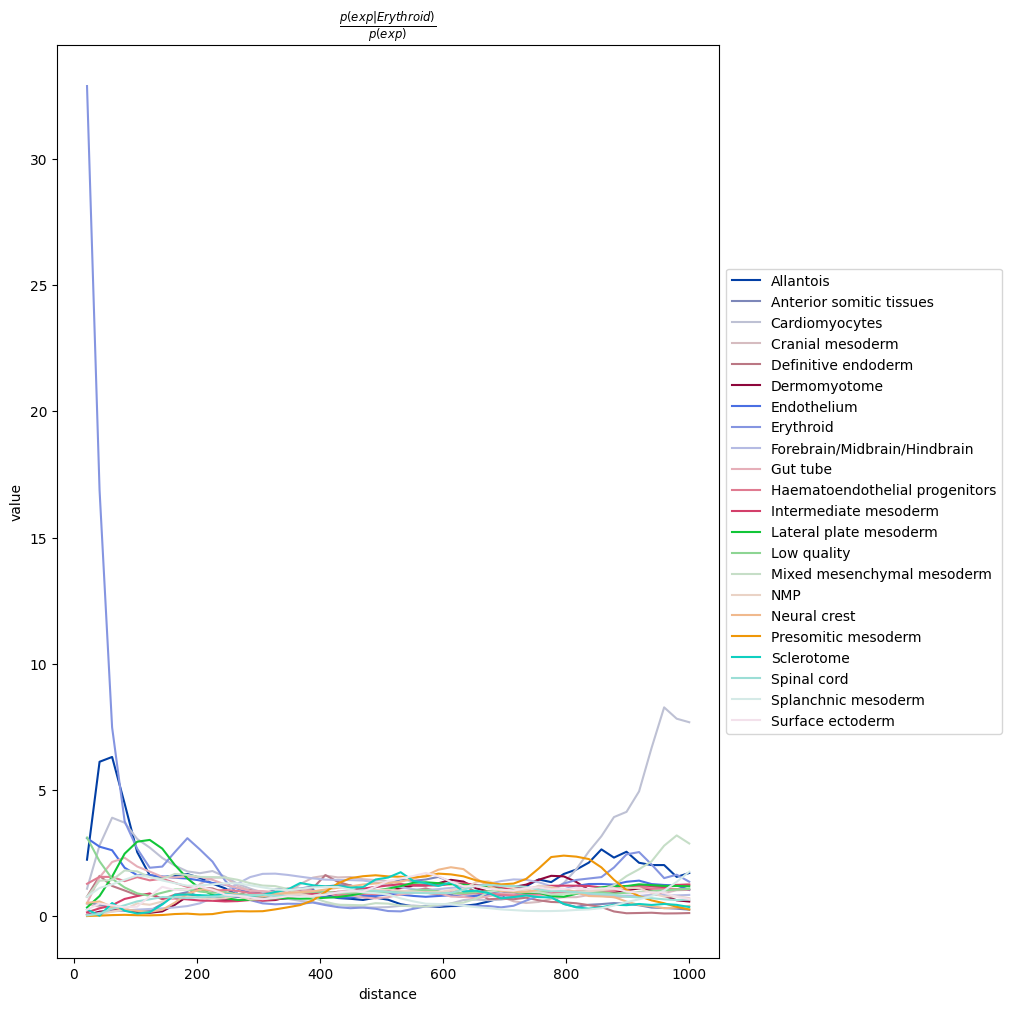

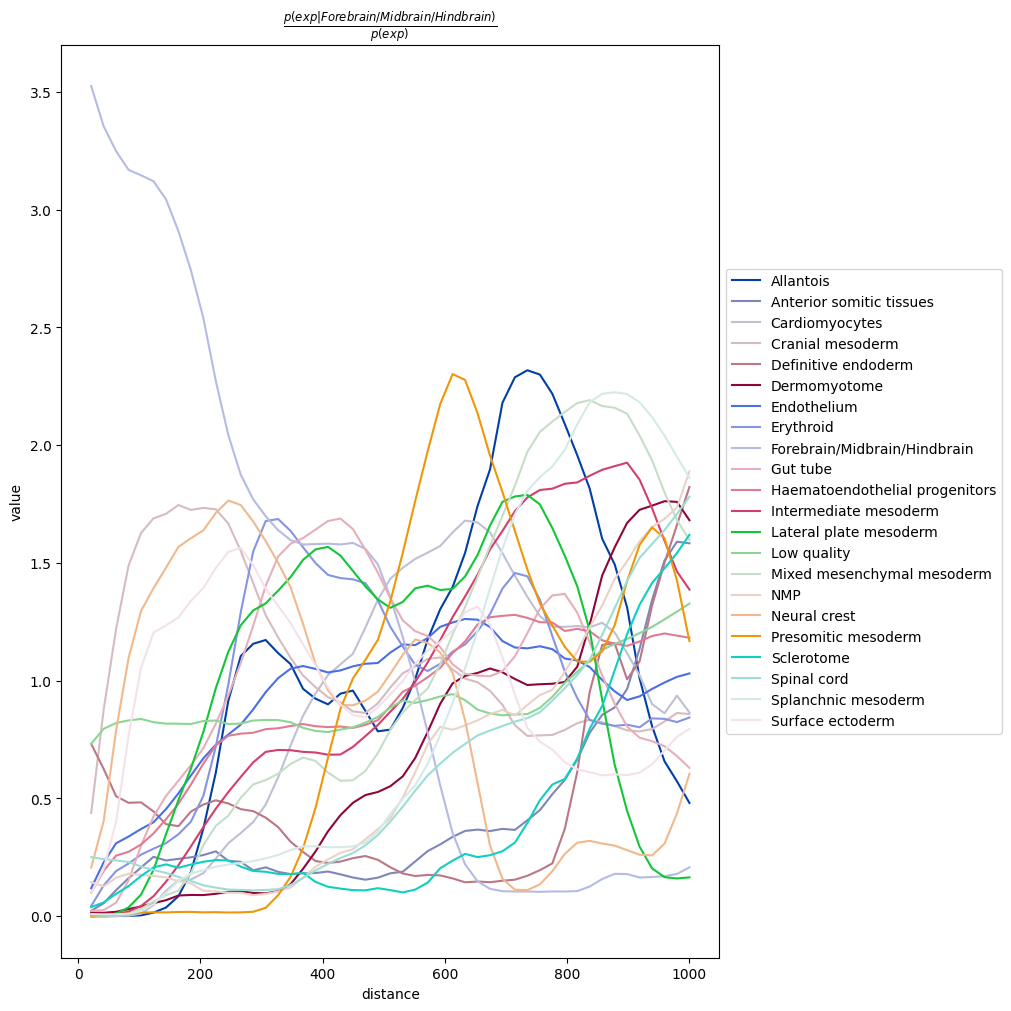

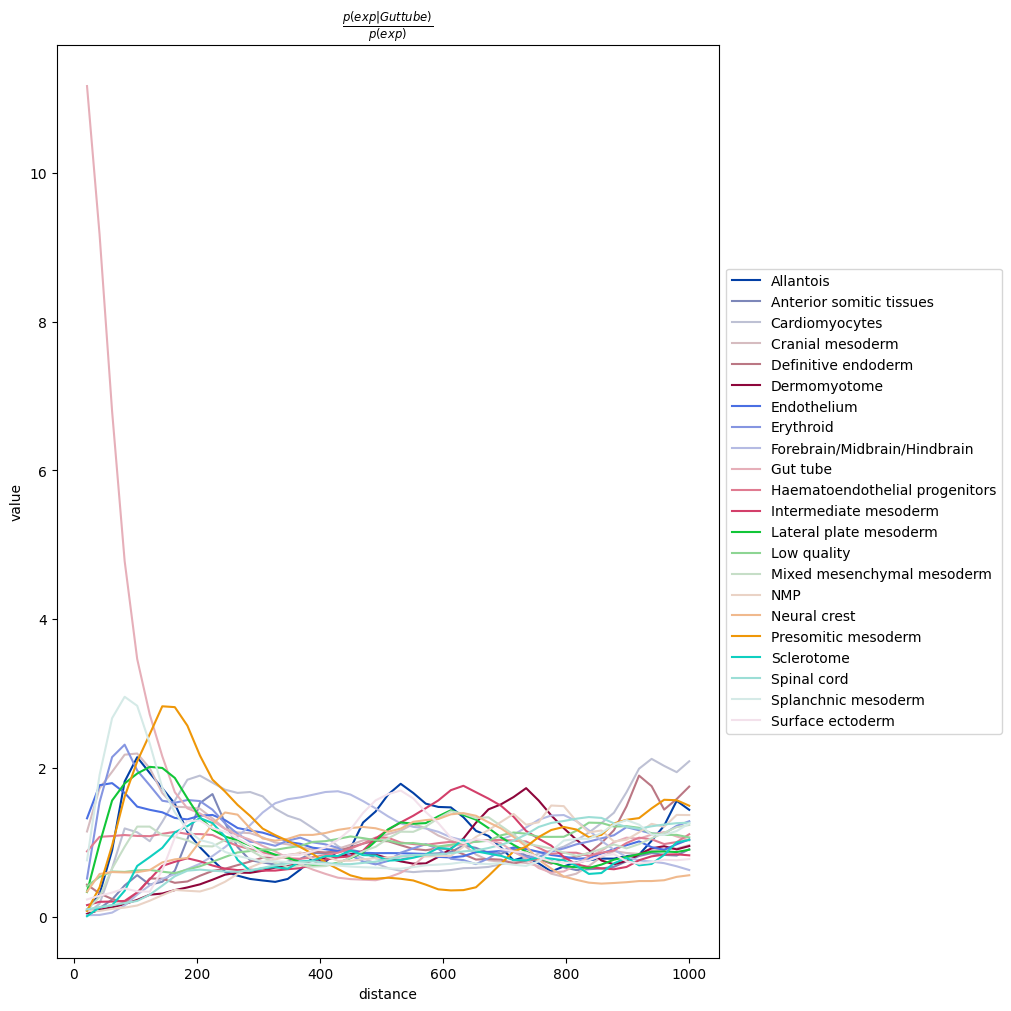

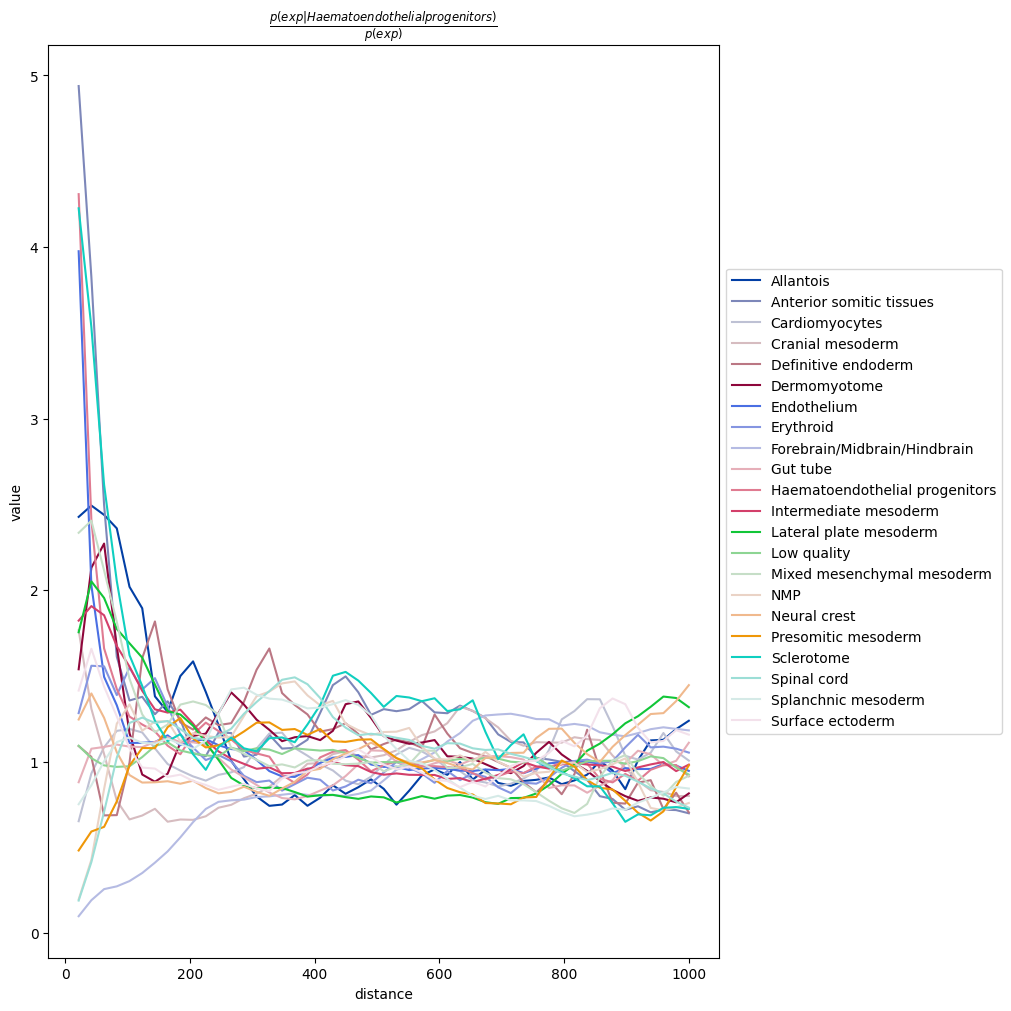

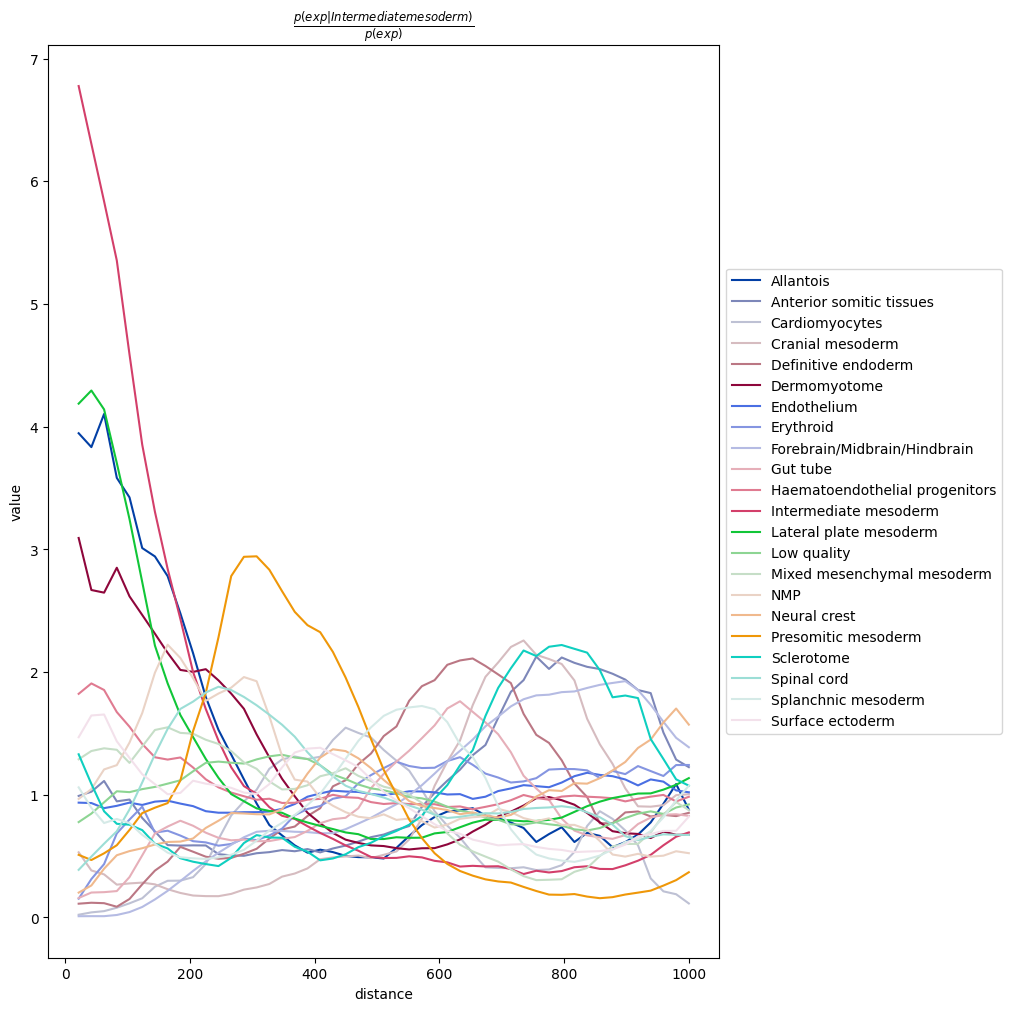

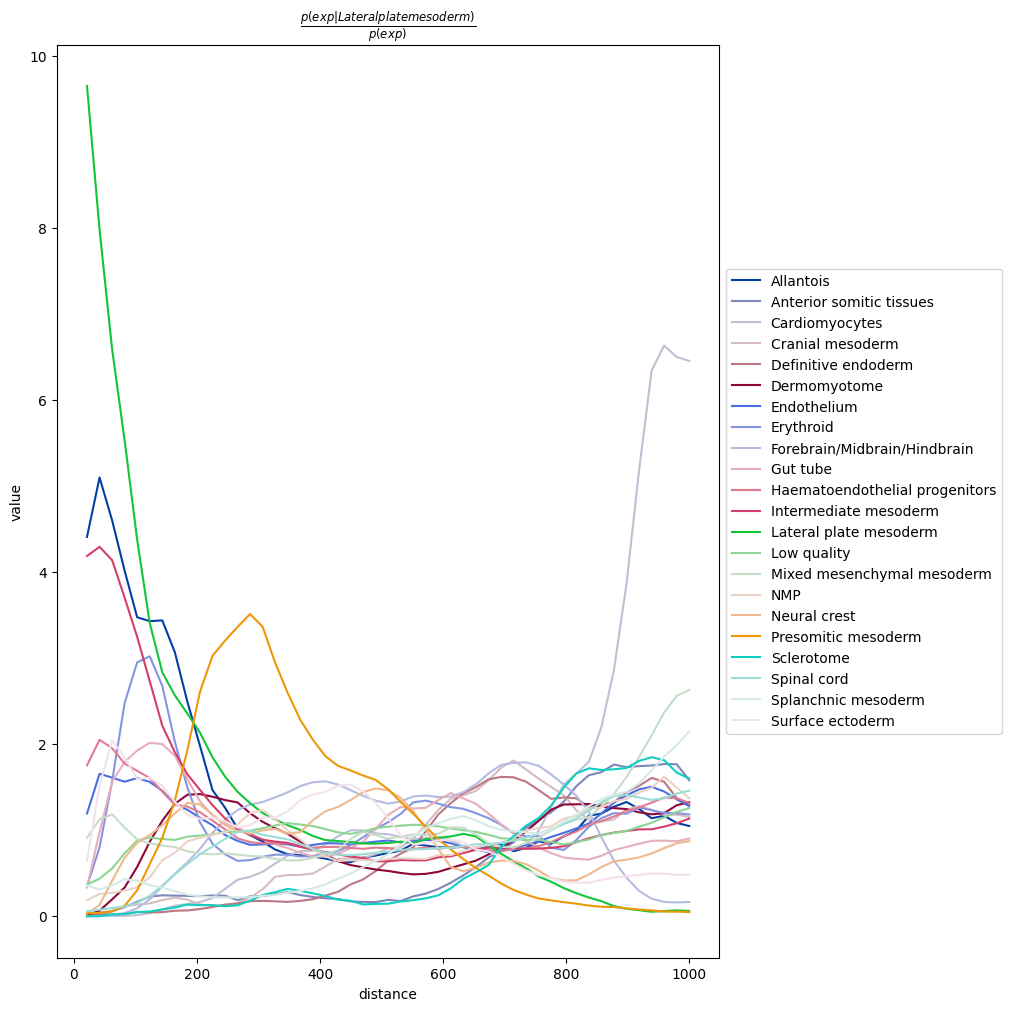

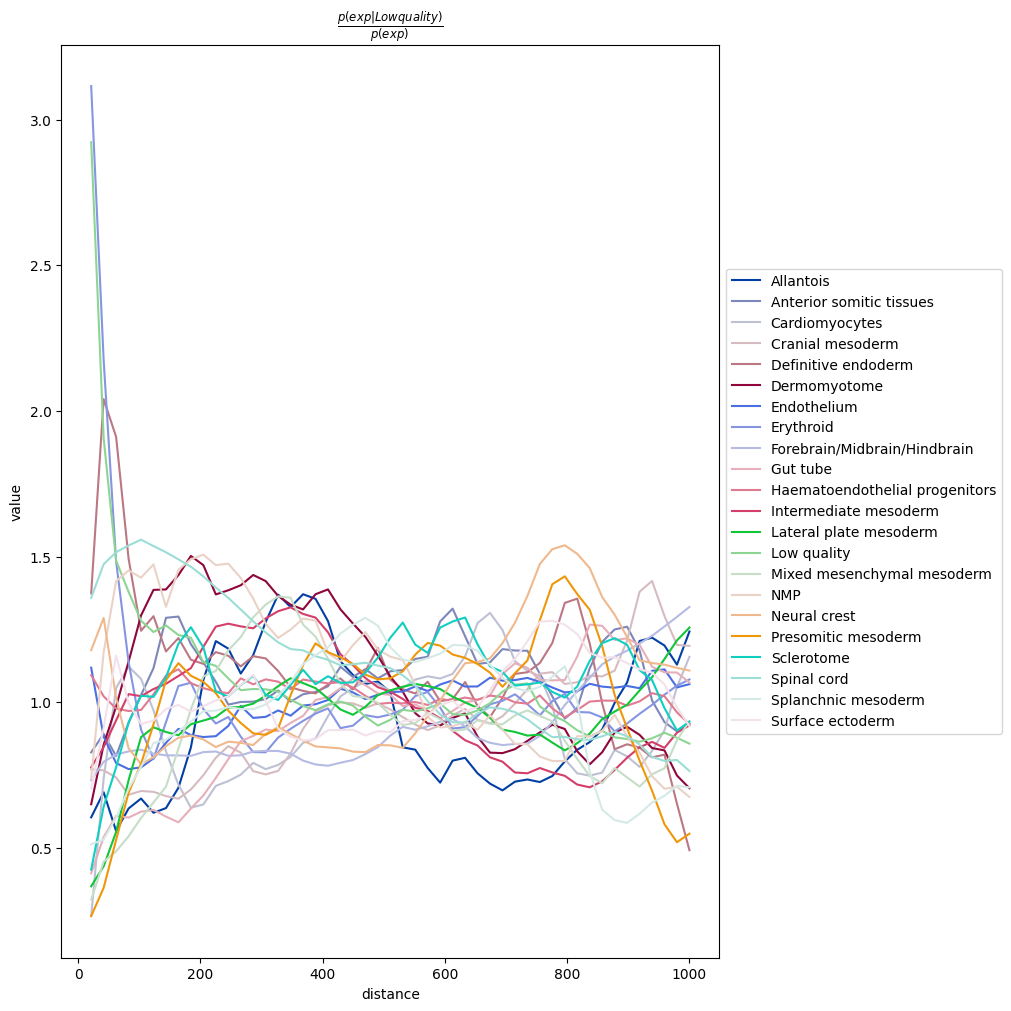

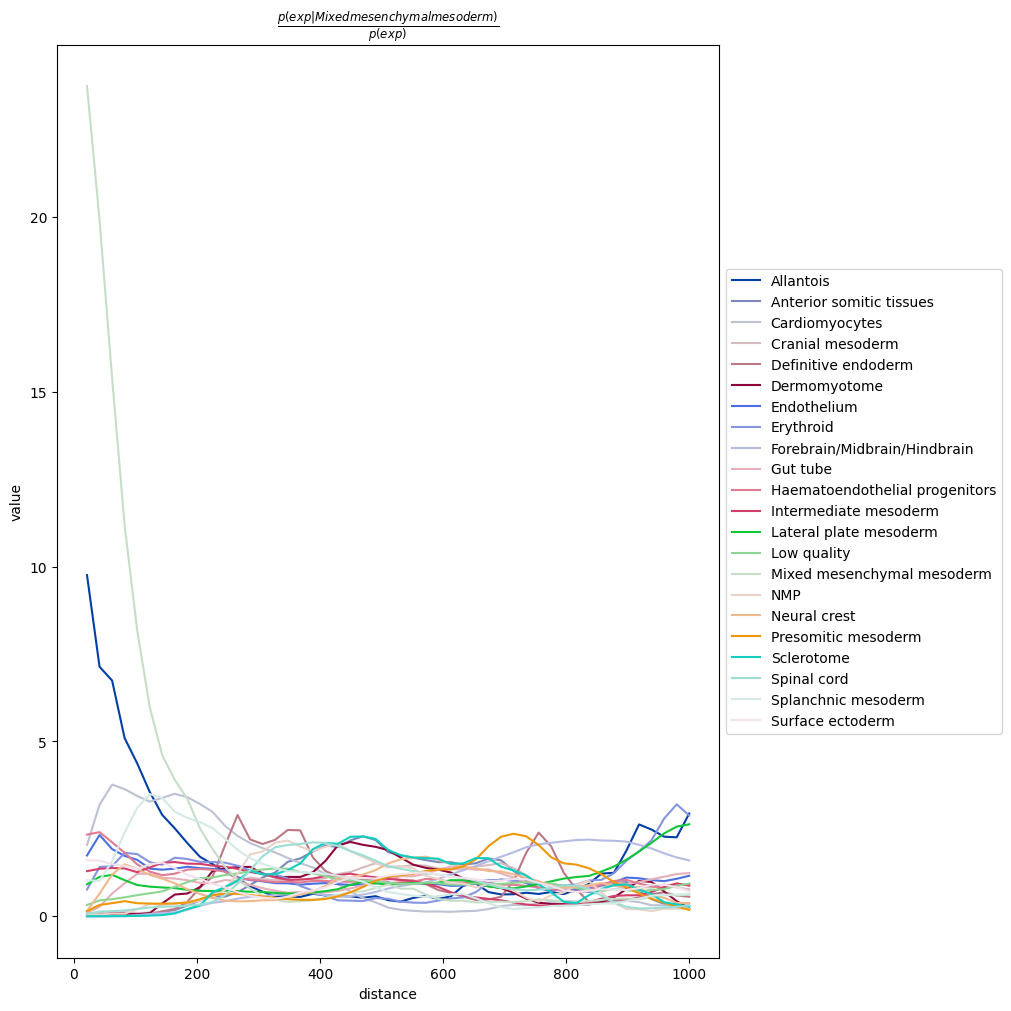

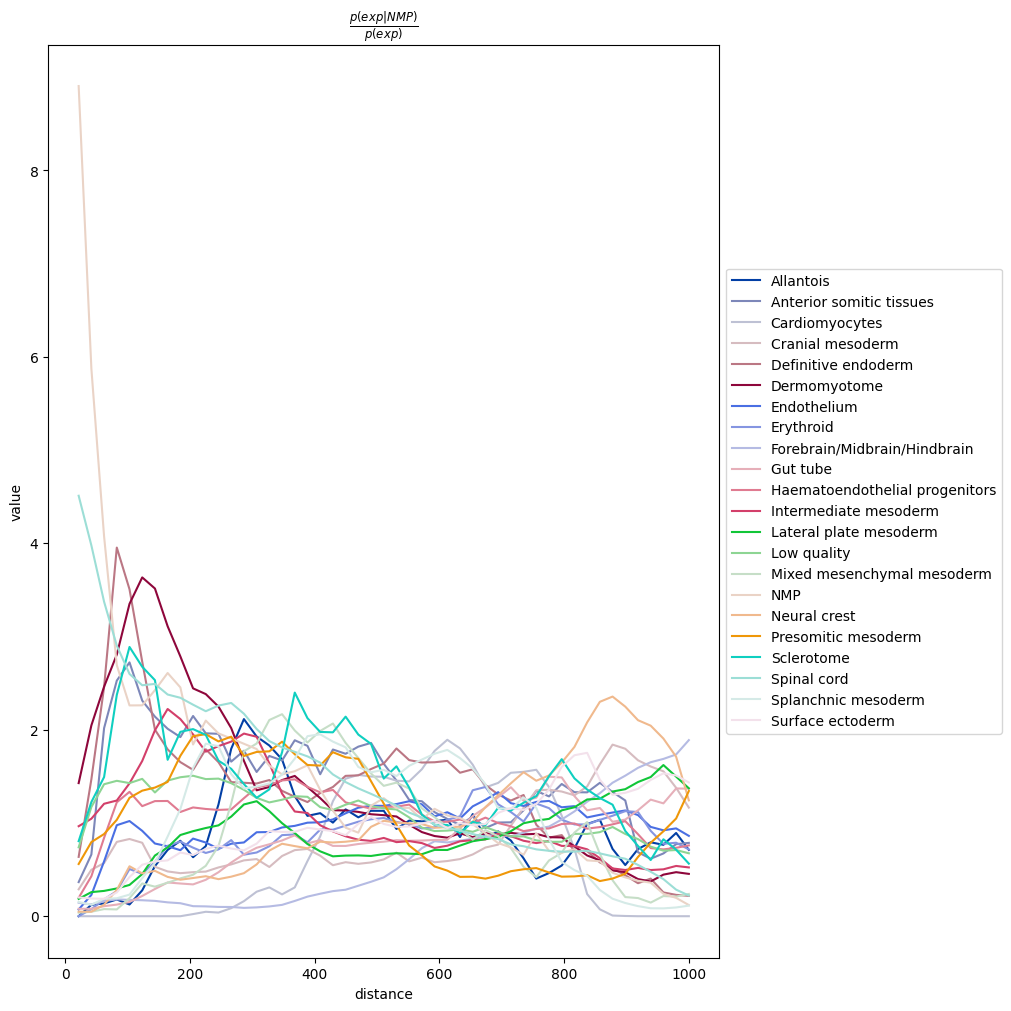

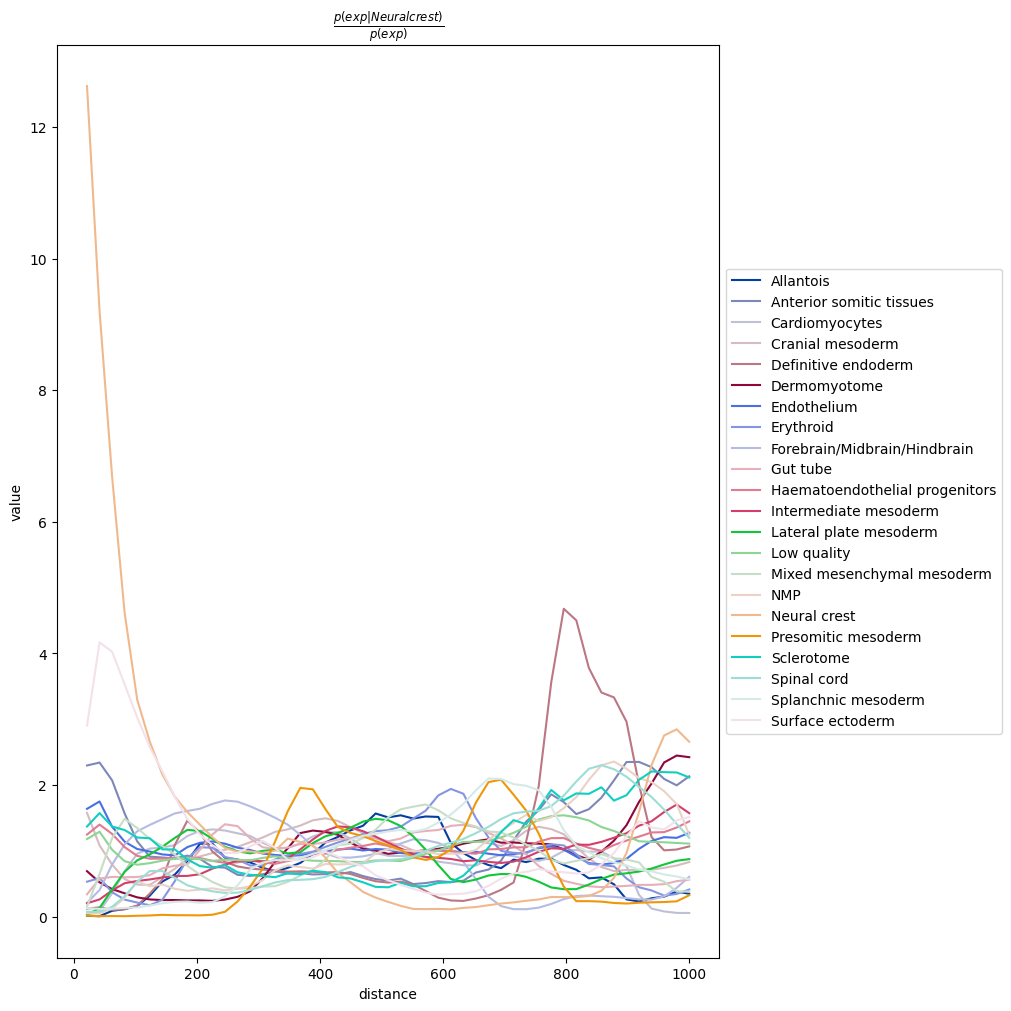

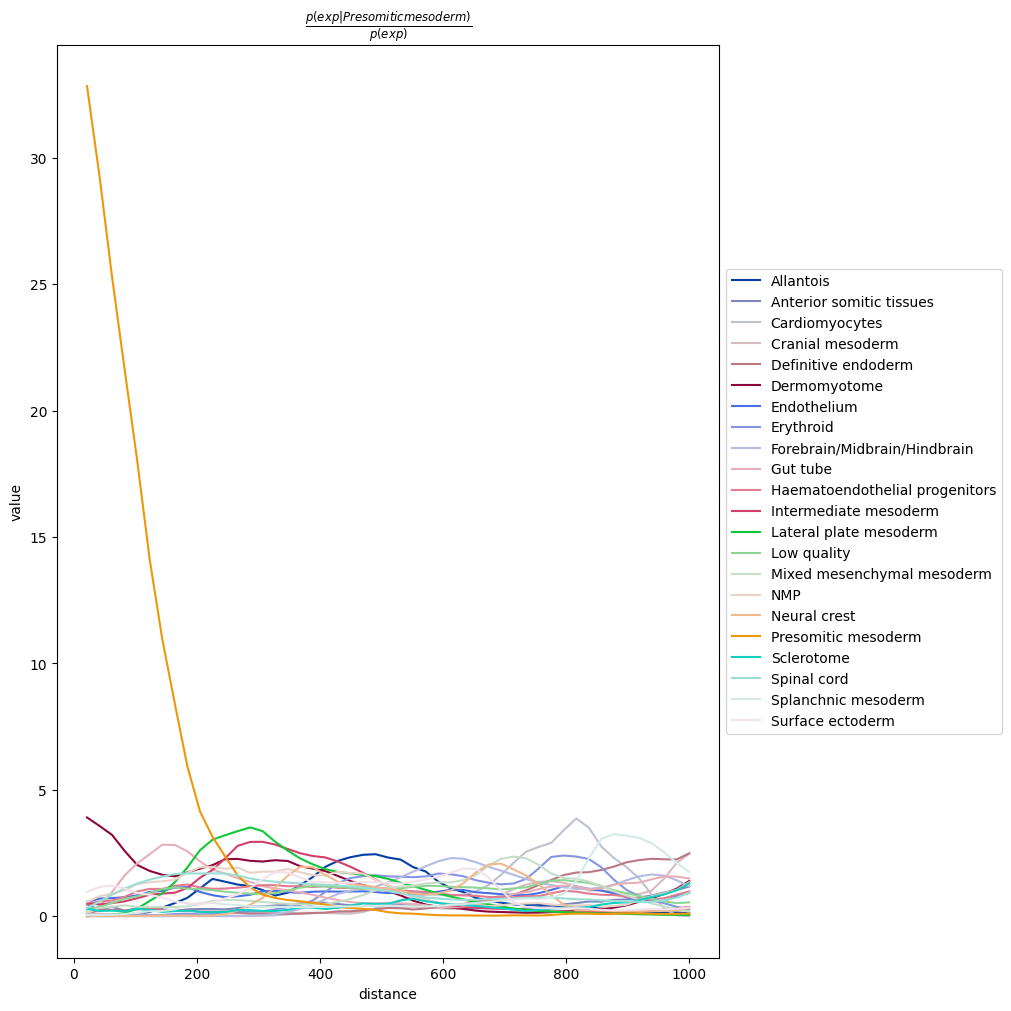

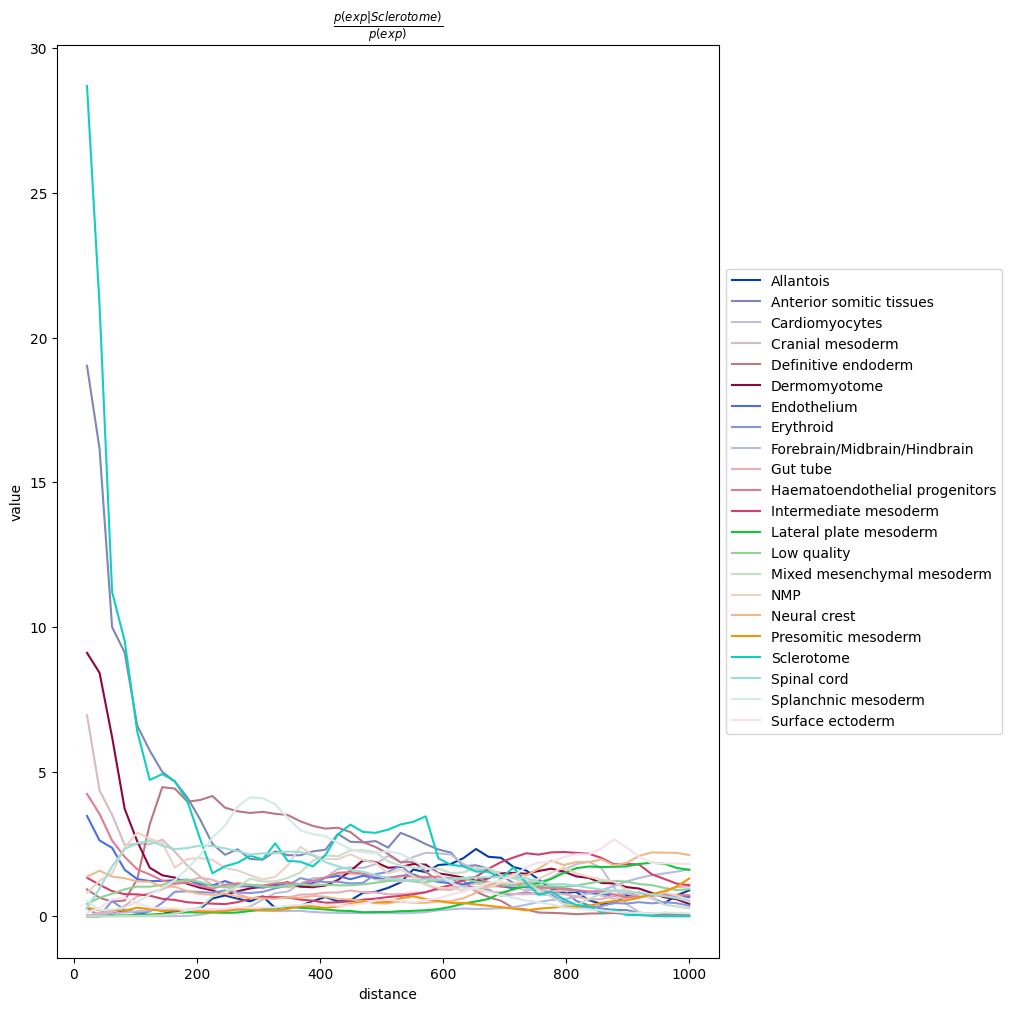

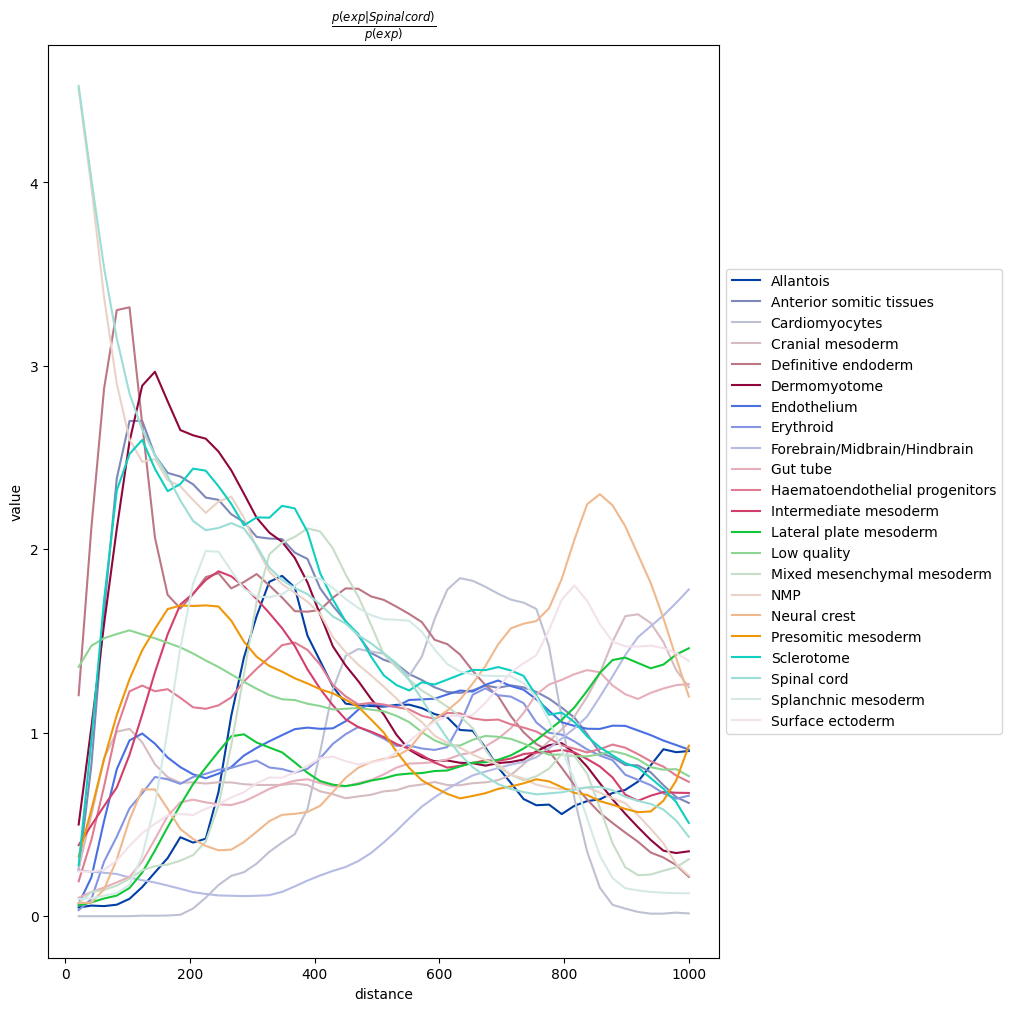

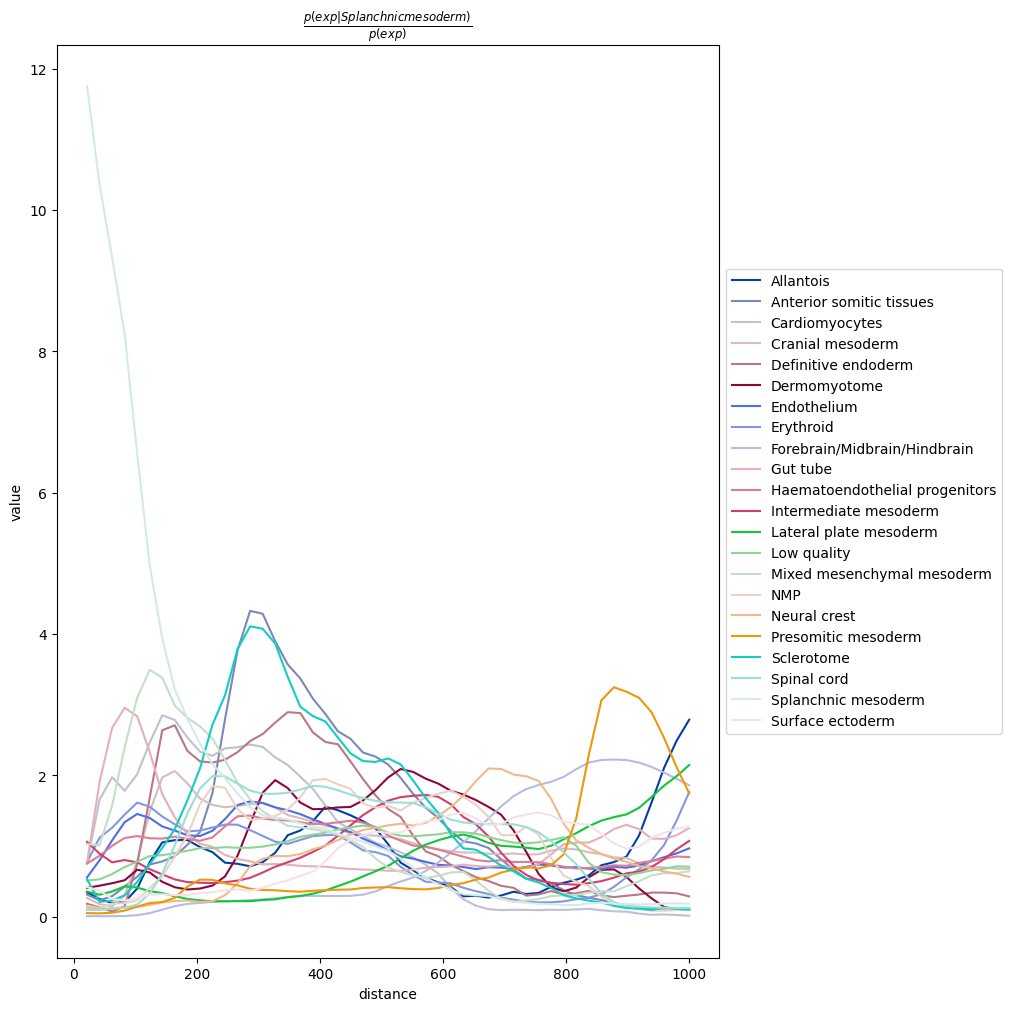

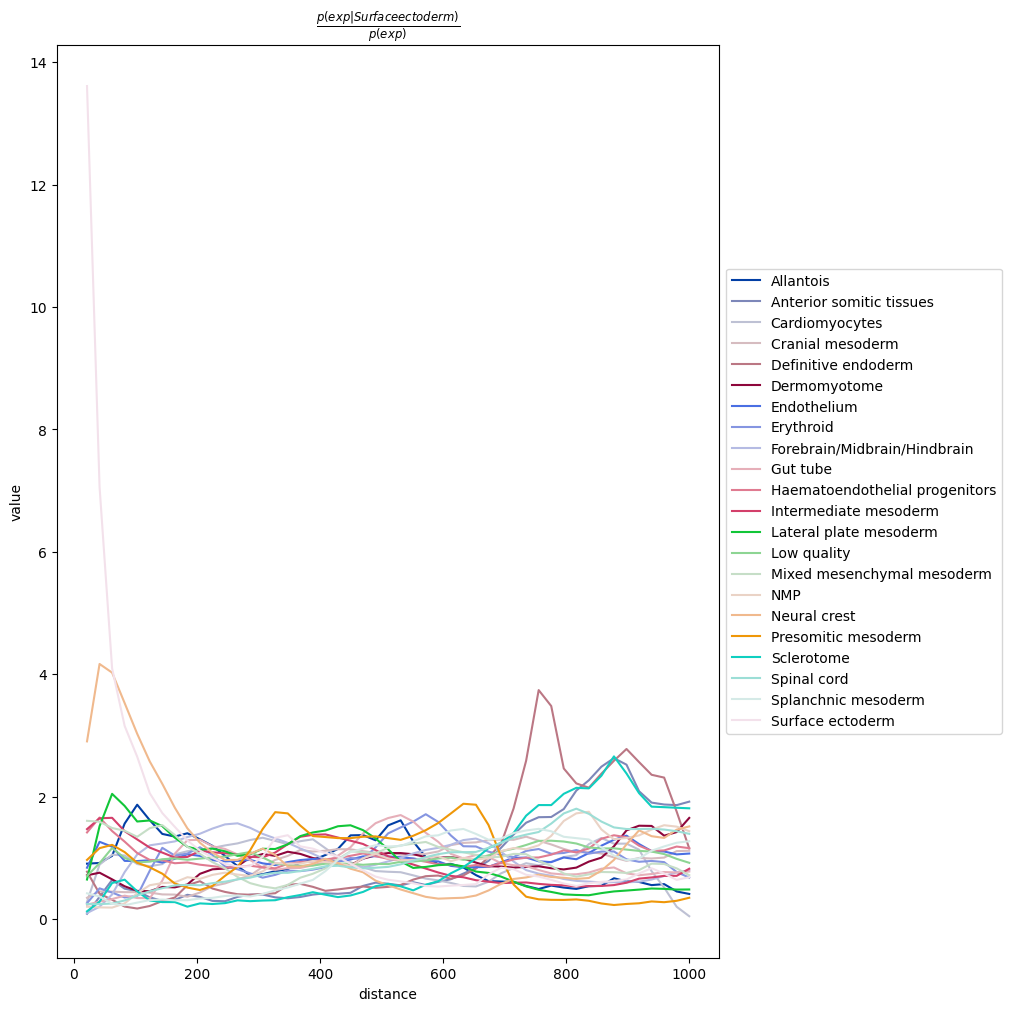

In [14]:
for ct in np.unique(adata.obs["celltypes"]):
    sq.pl.co_occurrence(adata, cluster_key="celltypes", clusters=ct,
                        save="simulation_co_occurance.{}.pdf".format(ct),
                        figsize=(10,10))

# Extract data

In [15]:
out = adata.uns["celltypes_co_occurrence"]["occ"]
interval = adata.uns["celltypes_co_occurrence"]["interval"][1:]
categories = adata.obs["celltypes"].cat.categories

## Create DF

In [16]:
cluster_key = "celltypes"

In [17]:
clusters = categories

In [18]:
fig, axs = plt.subplots(
        1,
        len(clusters),
        figsize=(5 * len(clusters), 5),
        dpi=300,
        constrained_layout=True,
    )
axs = np.ravel(axs)

In [19]:
df_dict = {}

for g, ax in zip(clusters, axs):
        print(g)
        idx = np.where(categories == g)[0][0]
        df = pd.DataFrame(out[idx, :, :].T, columns=categories).melt(var_name=cluster_key, value_name="probability")
        df["distance"] = np.tile(interval, len(categories))
        df["reference"] = g
        df_dict[g] = df


Allantois
Anterior somitic tissues
Cardiomyocytes
Cranial mesoderm
Definitive endoderm
Dermomyotome
Endothelium
Erythroid
Forebrain/Midbrain/Hindbrain
Gut tube
Haematoendothelial progenitors
Intermediate mesoderm
Lateral plate mesoderm
Low quality
Mixed mesenchymal mesoderm
NMP
Neural crest
Presomitic mesoderm
Sclerotome
Spinal cord
Splanchnic mesoderm
Surface ectoderm


In [20]:
result_df = pd.concat(df_dict.values(), axis=0, keys=df_dict.keys(), ignore_index=True)
result_df.head()

celltypes  probability    distance  reference
0  Allantois    28.236528   21.387754  Allantois
1  Allantois    14.861053   41.775509  Allantois
2  Allantois    11.182205   62.163265  Allantois
3  Allantois     7.556190   82.551018  Allantois
4  Allantois     5.412055  102.938774  Allantois

In [21]:
# > names(dat_50)
# [1] "perm"      "neighbor"  "Z"         "scale"     "reference" "id" 
# result_df.columns = ["neighbor", "Z", "scale", "reference"]
result_df.columns = ["neighbor", "probability", "distance", "reference"]

In [22]:
result_df["id"] = 0
result_df["perm"] = 1
result_df.head()

neighbor  probability    distance  reference  id  perm
0  Allantois    28.236528   21.387754  Allantois   0     1
1  Allantois    14.861053   41.775509  Allantois   0     1
2  Allantois    11.182205   62.163265  Allantois   0     1
3  Allantois     7.556190   82.551018  Allantois   0     1
4  Allantois     5.412055  102.938774  Allantois   0     1

In [23]:
result_df.to_csv('results_data/dat_seq_squidpy.csv')